# Programming Assignment 6: Face Detection using the R-CNN

## Overview

<font size='4'>In this optional assignment, you will practice training a R-CNN model for face detection based on the PyTorch framework. You will implement data praparing, model definition, loss computing, and hyper parameters tuning. It will help you better understand modern proposal-based object detection systems.</font>

<font size='4'>After finishing this assignment, you should be able to extend it to the Faster R-CNN model. If you plan to work on a project that uses object detection (for example, autonomous driving, augmented reality, etc), although there are existing implementations, you are encouraged to do so to deepen your understanding of relevant techniques.</font>

## Submission format
- <font size='4'>\<your_nu_username\>_r-cnn.ipynb

## Note:
- <font size='4'>You do not install any additional packages inside the Colab environment. Do not forget to choose to use GPU in the `Runtime\Change runtime type` tab.
- <font size='4'>We have an inline question embedded in the Jupyter notebook file at the end. Do not miss it.

## Setup

In [1]:
# download some data
!wget https://jianghz.me/teaching/cs5330/fall2021/assets/faces.zip
!unzip -q faces.zip

!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics.git
!cp Object-Detection-Metrics/lib/*.py .

--2022-12-14 20:14:51--  https://jianghz.me/teaching/cs5330/fall2021/assets/faces.zip
Resolving jianghz.me (jianghz.me)... 74.220.219.156
Connecting to jianghz.me (jianghz.me)|74.220.219.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55340449 (53M) [application/zip]
Saving to: ‘faces.zip’

faces.zip           100%[===================>]  52.78M  30.3MB/s    in 1.7s    

2022-12-14 20:14:53 (30.3 MB/s) - ‘faces.zip’ saved [55340449/55340449]

Cloning into 'Object-Detection-Metrics'...
remote: Enumerating objects: 567, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 567 (delta 33), reused 39 (delta 14), pack-reused 500
Receiving objects: 100% (567/567), 10.64 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (255/255), done.


In [485]:
# As usual, a bit of setup
from __future__ import print_function
import os

# PyTorch related
import torch
import torch.nn as nn
import torchvision.models as models

import numpy as np
import cv2
import copy

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from utils import BBType, BBFormat, CoordinatesType
from Evaluator import Evaluator

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [486]:
# define two useful global variables and some helpful functions
_PIX_MEAN_ = [0.485, 0.456, 0.406]
_PIX_STD_ = [0.229, 0.224, 0.225]

def bbox_iou(boxA, boxB):
    """
    credit: https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc
    """
    boxA[2] = boxA[0] + boxA[2]
    boxA[3] = boxA[1] + boxA[3]
    boxB[2] = boxB[0] + boxB[2]
    boxB[3] = boxB[1] + boxB[3]

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def evaluate_face_detection(gt_boxes_dict, pred_boxes_dict):
    allBoundingBoxes = BoundingBoxes()
    
    # process ground truth
    id_class = 1     # only face
    for im_path, boxes in gt_boxes_dict.items():
        for i in range(boxes.shape[0]):
            x, y, w, h = boxes[i, :]
            bb = BoundingBox(
                im_path, id_class,
                x, y, w, h, 
                typeCoordinates=CoordinatesType.Absolute, 
                imgSize=(0, 0),
                bbType=BBType.GroundTruth,
                format=BBFormat.XYWH
            )
            allBoundingBoxes.addBoundingBox(bb)
            
    # process detections
    for im_path, dets in pred_boxes_dict.items():
        for i in range(dets.shape[0]):
            x, y, w, h, conf = dets[i, :]
            bb = BoundingBox(
                im_path, id_class,
                x, y, w, h, 
                typeCoordinates=CoordinatesType.Absolute, 
                imgSize=(0, 0),
                bbType=BBType.Detected,
                classConfidence=conf,
                format=BBFormat.XYWH
            )
            allBoundingBoxes.addBoundingBox(bb)
            
    evaluator = Evaluator()
    metrics = evaluator.GetPascalVOCMetrics(allBoundingBoxes)
    return metrics

def draw_boxes(im, det_boxes, det_prob_thresh, gt_boxes=None):
    for i in range(det_boxes.shape[0]):
        x, y, w, h, conf = det_boxes[i, :]
        if conf > det_prob_thresh:
            x1 = int(x)
            y1 = int(y)
            x2 = int(x + w + 1)
            y2 = int(y + h + 1)
            im = cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
    if gt_boxes is not None:
        for i in range(gt_boxes.shape[0]):
            x, y, w, h = gt_boxes[i, :]
            x1 = int(x)
            y1 = int(y)
            x2 = int(x + w + 1)
            y2 = int(y + h + 1)
            im = cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return im

## Part 1: Prepare Data (15 points)

<font size='4' color='red'>**Task 1: Preparing ground-truth lables and coordinates offsets for object proposals (15 points).**</font>

In [487]:
class FaceDataset(torch.utils.data.Dataset):
    """
    This is our custom dataset that provides data for training and validation.
    Check https://pytorch.org/docs/stable/data.html for more details.
    """
    def __init__(self, im_dir, annot_file_path, proposal_file_path, num_boxes_to_sample=4, 
            pos_iou_thresh=0.5, pos_ratio=0.25, canonical_dim=(224, 224), is_train=True):
        """
        Prepare the data related to object proposals

        Inputs:
        - im_dir: image directory
        - annot_file_path: a txt file storing the ground-truth boxes for each image
        - proposal_file_path: a txt file storing all object proposals for each image
        - num_boxes_to_sample: number of bounding boxes to sample from a single image
        - pos_io_thresh: when comparing a proposal (bounding box) to a ground-truth, if the iou
          is greater than this threshold, it is considered as positive. Otherwise negative.
        - pos_ratio: when randomly sample object proposals for a single image, the ratio of
          positive ones
        - canonical_dim: canonical spatial dimension to resize a cropped image corresponding
          to an object proposal
        - is_train: whether the dataset is used for training or not
        """
        self.im_dir = im_dir
        self.num_boxes_to_sample = num_boxes_to_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.pos_ratio = pos_ratio
        self.canonical_dim = canonical_dim
        self.is_train = is_train
        
        # read annotations and object proposals
        print('==> Loading gt boxes from file.')
        gt_boxes = self.read_boxes_from_file(im_dir, annot_file_path)
        print('==> Loading object proposals from file.')
        proposals = self.read_boxes_from_file(im_dir, proposal_file_path)
        assert len(list(gt_boxes.keys())) == len(list(proposals.keys()))
        
        self.aug_proposal_list = []
        
        # get labels for each object proposal
        print('==> Getting ground-truths for each object proposal')
        for im_path_i, gt_boxes_i in gt_boxes.items():
            proposals_i = proposals[im_path_i]
            labs_i, offsets_i = self.get_proposals_lab_offset(
                gt_boxes_i.copy(), 
                proposals_i.copy(),
                self.pos_iou_thresh
            )
            if np.sum(labs_i) == 0:
                print('{}, {}'.format(im_path_i, np.sum(labs_i)))
            self.aug_proposal_list.append([im_path_i, proposals_i, labs_i, offsets_i, gt_boxes_i])
                
    def read_boxes_from_file(self, im_dir, file_path):
        data_dict = {}
        with open(os.path.join(im_dir, file_path), 'r') as f:
            num_ims = int(f.readline().strip())
            for _ in range(num_ims):
                im_name = f.readline().strip()
                im_path = os.path.join(im_dir, im_name)
                assert os.path.exists(im_path)
                num_boxes = int(f.readline().strip())
                boxes = np.zeros((num_boxes, 4), dtype=int)
                for ix in range(num_boxes):
                    spatial_dims = f.readline().strip().split(' ')
                    spatial_dims = [int(x) for x in spatial_dims]
                    boxes[ix, :] = spatial_dims
                assert im_path not in data_dict
                data_dict[im_path] = boxes
        return data_dict
                
    def get_proposals_lab_offset(self, gt_boxes, proposals, pos_iou_thresh):
        """
        Given a set of ground-truth bounding boxes and object proposals, find their matchings and
        assign labels and offsets for each object proposal. In specific, for each object proposal,
        find the ground-truth bounding box that has the largest IoU with it. If the largest IOU is
        greather than the specified threshold, it is positive. Otherwise, it is negative. For a 
        positive object proposal, we also need to compute its offsets of coordinates form the 
        corresponding ground-truth bounding box.

        Inputs:
        - gt_boxes: a numpy array of [M, 4] containing ground-truth bounding boxes in the x, y, w, h format
        - proposals: a numpy array of [N, 4] containing object proposals in the x, y, w, h format
        - pos_iou_thresh: if an IoU score is greater than this threshold, an object proposal is considered
          as positive. Otherwise negative.

        Outputs:
        - labs: a numpy array of (N,) containing the labels for all the object proposals
        - offsets: a numpy array of (N, 4) containing the coordinates offsets of the object proposals
        """
        num_proposals = proposals.shape[0]
        labs = np.zeros(num_proposals)
        offsets = np.zeros((num_proposals, 4))
        ##############################################################################################
        # Finish your implementation here. You may find the bbox_iou function useful.                #
        ##############################################################################################
        
        for i in range(num_proposals):
          proposal = proposals[i]
          # print("Proposal", proposal)

          iou = []
          for gt in gt_boxes:
            iou.append(bbox_iou(proposal, gt))
          # print("IOU", iou)

          best_idx = np.argmax(iou)
          best_iou = iou[best_idx]
          # print(best_iou, ",", best_idx)

          if best_iou >= pos_iou_thresh:
            labs[i] = 1
            offsets[i] = proposal - gt_boxes[best_idx]

          else:
            labs[i] = 0

        ##############################################################################################
        # End of your implementation.                                                                #
        ##############################################################################################

        return labs, offsets                 
                    
    def __len__(self):
        return len(self.aug_proposal_list)
    
    def get_crop_im(self, im, x, y, w, h):
        """
        """
        imh, imw, _ = im.shape
        x2 = min(x + w, imw)
        y2 = min(y + h, imh)
        x1 = max(x, 0)
        y1 = max(y, 0)
        im_crop = im[y1 : y2, x1 : x2]
        im_crop = cv2.resize(im_crop, self.canonical_dim, None)
        return im_crop
    
    def __getitem__(self, idx):
        # boxes are object proposals
        im_path, boxes, labs, offsets, gt_boxes = self.aug_proposal_list[idx]
        
        if self.is_train:        
            # let's randomly sample image crops
            pos_idxes = np.where(labs > 0)[0]
            neg_idxes = np.where(labs == 0)[0]
            num_pos = min(int(self.num_boxes_to_sample * self.pos_ratio), len(pos_idxes))
            num_neg = self.num_boxes_to_sample - num_pos
            
            np.random.shuffle(pos_idxes)
            np.random.shuffle(neg_idxes)
            
            pos_boxes = boxes[pos_idxes[:num_pos], :]
            pos_labs = labs[pos_idxes[:num_pos]]
            pos_offsets = offsets[pos_idxes[:num_pos], :]
            
            neg_boxes = boxes[neg_idxes[:num_neg], :]
            neg_labs = labs[neg_idxes[:num_neg]]
            neg_offsets = offsets[neg_idxes[:num_neg], :]
            
            # print(pos_boxes.shape, neg_boxes.shape, boxes.shape)
            boxes = np.vstack((pos_boxes, neg_boxes))
            # import pdb; pdb.set_trace()
            labs = np.hstack((pos_labs, neg_labs))
            offsets = np.vstack((pos_offsets, neg_offsets))
            
        # get real image crops
        im = cv2.imread(im_path).astype(np.float32)
        # BGR -> RGB
        im = im[:, :, ::-1]
        crop_im_list = []
        for i in range(boxes.shape[0]):
            x, y, w, h = boxes[i, :]
            crop_im = self.get_crop_im(im, x, y, w, h)
            # normalization
            crop_im = (crop_im - _PIX_MEAN_) / _PIX_STD_
            crop_im_list.append(torch.from_numpy(crop_im.transpose(2, 0, 1)))
        crop_ims = torch.stack(crop_im_list, dim=0)
        
        if self.is_train:
            return crop_ims, torch.from_numpy(labs).long(), torch.from_numpy(offsets)
        
        return crop_ims, boxes, labs, offsets,  gt_boxes, im_path

==> Loading gt boxes from file.
==> Loading object proposals from file.
==> Getting ground-truths for each object proposal
faces/train/0_Parade_marchingband_1_353.jpg, 0.0
faces/train/16_Award_Ceremony_Awards_Ceremony_16_116.jpg, 0.0
faces/train/17_Ceremony_Ceremony_17_1007.jpg, 0.0
faces/train/17_Ceremony_Ceremony_17_972.jpg, 0.0
faces/train/19_Couple_Couple_19_88.jpg, 0.0
faces/train/19_Couple_Couple_19_631.jpg, 0.0
faces/train/19_Couple_Couple_19_90.jpg, 0.0
faces/train/19_Couple_Couple_19_349.jpg, 0.0
faces/train/19_Couple_Couple_19_822.jpg, 0.0
faces/train/20_Family_Group_Family_Group_20_750.jpg, 0.0
faces/train/21_Festival_Festival_21_664.jpg, 0.0
faces/train/22_Picnic_Picnic_22_561.jpg, 0.0


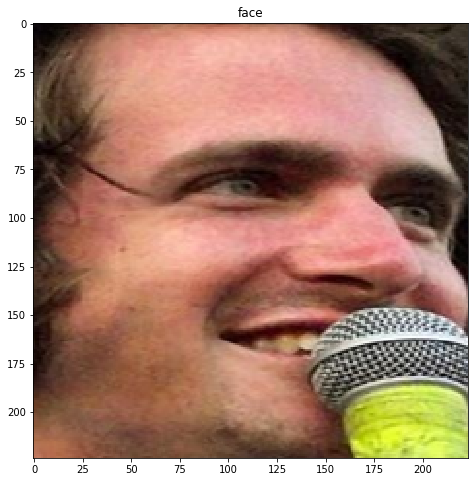

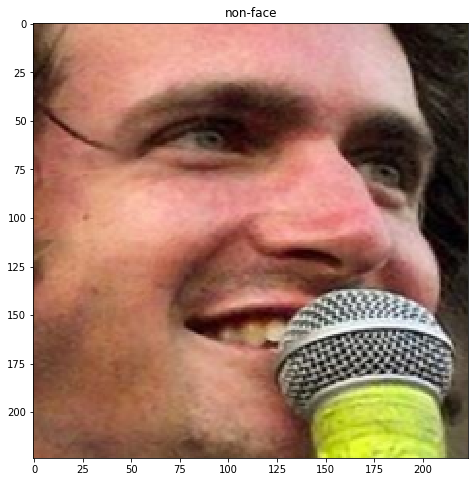

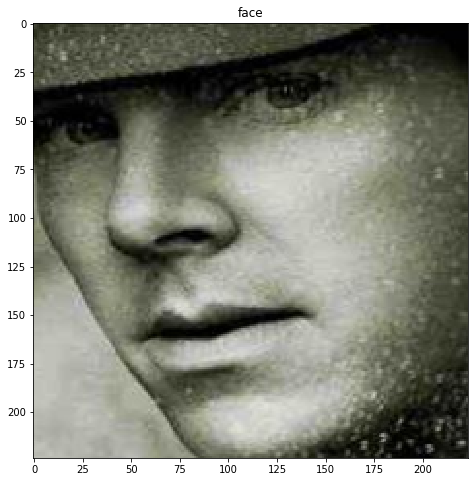

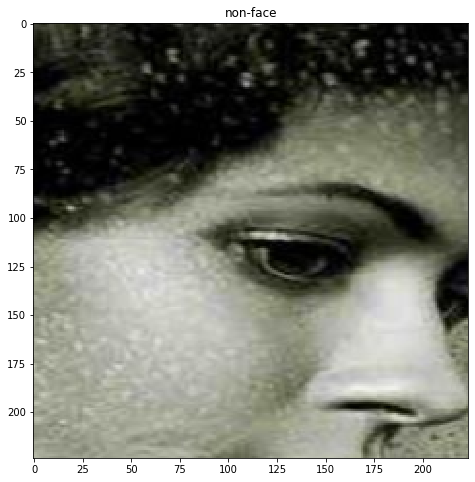

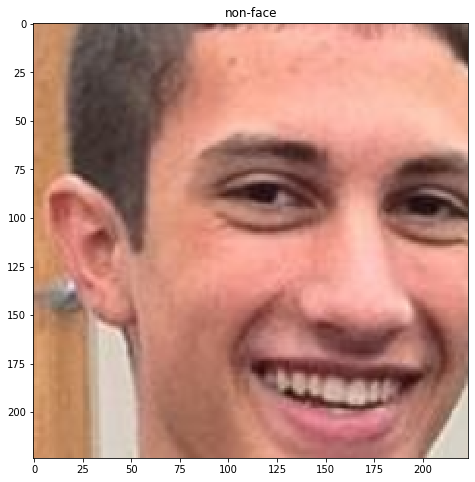

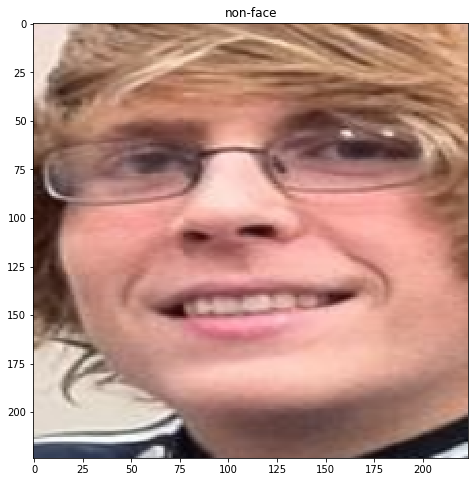

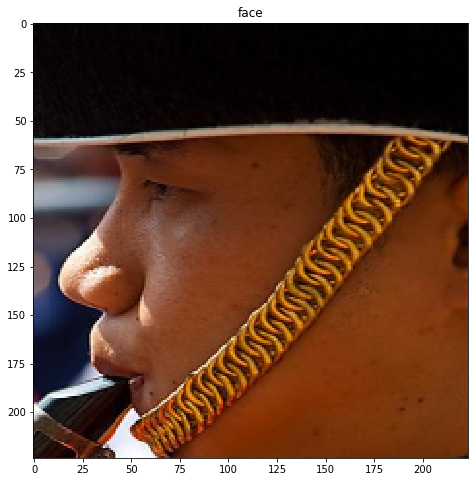

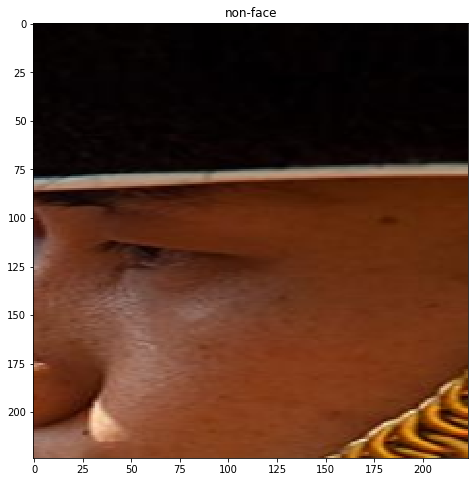

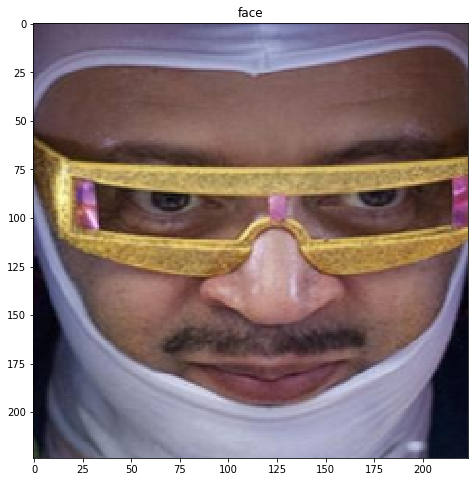

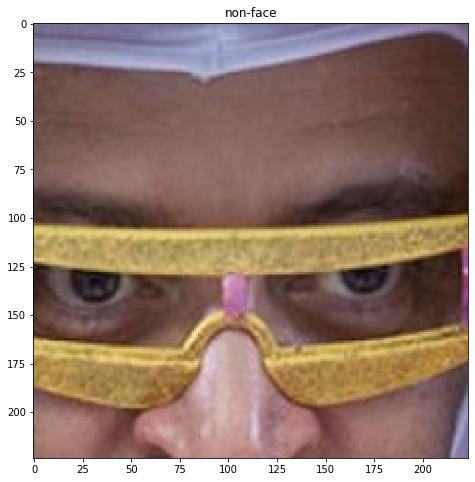

In [488]:
# Let's visualize some examples
plt.close()

dataset = FaceDataset(
    'faces/train',
    'gt_boxes.txt',
    'proposals.txt',
    num_boxes_to_sample=2,
    pos_iou_thresh=0.5,
    pos_ratio=0.5
)

for i, data in enumerate(dataset):
    if i > 4:
        break

    crop_ims, labs, offsets = data
    for j in range(crop_ims.shape[0]):
        if labs[j] == 1:
            lab_str = 'face'
        else:
            lab_str = 'non-face'
        crop_im_i = crop_ims[j].numpy().transpose(1, 2, 0)
        crop_im_i = crop_im_i * _PIX_STD_ + _PIX_MEAN_
        plt.figure()
        plt.imshow(crop_im_i.astype(np.uint8))
        plt.title(lab_str)
        
plt.show()

## Part 2: Define R-CNN model (10 points)

<font size='4' color='red'>**Task 2: define the output layers (5 points) and finish the forward pass (5 points).**</font>

In [489]:
class R_CNN_Detector(nn.Module):
    """
    This is PyTorch model that estimates classifcation logits as well as coordinates offsets given an image crop.
    """
    def __init__(self, num_classes=1, use_imagenet_pretrain=True):
        """
        Define the model.

        Inputs:
        - num_classes: number of classes of interest. In our case, face only. But remember we also have the background
          class. So the actual number of classes is num_classes+1.
        - use_imagenet_pretrain: whether to use an ImageNet pre-trained backbone or not.
        """
        super(R_CNN_Detector, self).__init__()
        
        # a ResNet backbone. We remove the last classification layer.
        # check https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py for more details
        backbone = models.resnet34(pretrained=use_imagenet_pretrain)
        backbone = list(backbone.children())[:-1]
        backbone = nn.Sequential(*backbone)
        self.backbone = backbone
        self.backbone_num_channels = 512

        # output layer
        ##############################################################################################
        # Implement two output layers: one for classifcation and the other for regression            #
        # Check https://pytorch.org/docs/stable/nn.html for more details                             #
        ##############################################################################################
        
        self.classifier = nn.Linear(in_features=self.backbone_num_channels, out_features=num_classes+1)
 
        self.regressor = nn.Linear(in_features=self.backbone_num_channels, out_features=num_classes*4)

        ##############################################################################################
        # End of your implementation.                                                                #
        ##############################################################################################
        
    def forward(self, im):
        """
        In this function, we compute the classifcation logits and regression results.
        PyTorch takes care of the backward pass for us automatically.
        """
        # B x C
        features = self.backbone(im).squeeze()
        
        cls_logits, reg_offsets = None, None
        ##############################################################################################
        # Implement the forward pass to compute cls_logits and reg_offsets                           #
        ##############################################################################################
        
        # Calculate the classification logits
        cls_logits = self.classifier(features)
        

        # Calculate the coordinates offsets
        reg_offsets = self.regressor(features)
        
        ##############################################################################################
        # End of your implementation.                                                                #
        ##############################################################################################

        return cls_logits, reg_offsets

In [490]:
# Let's test your model
model = R_CNN_Detector()
x = torch.rand((2, 3, 64, 64))
logits, offsets = model(x)
assert logits.shape == (2, 2)
assert offsets.shape == (2, 4)

print(logits)
print(offsets)

tensor([[-0.7915, -0.0922],
        [ 0.5598,  0.2693]], grad_fn=<AddmmBackward0>)
tensor([[-1.6775,  1.0609,  0.4217,  0.5419],
        [-0.2803,  1.0120, -0.8080,  0.1615]], grad_fn=<AddmmBackward0>)


## Part 3: Train the model (75 points)

<font size='4' color='red'>**Task 3.1: Define the loss functions (10 points) and compute loss terms in the model training part (10 points).**</font>

In [491]:
def train_and_validate(lr=0.1, loss_reg_weight=1, imagenet_pretrain=True, device='cpu'):
    """
    In this function, we perform model instantiation, training, and validation.
    As we don't have a testing set, we skip the model testing part.
    """

    # define training and validation data loaders
    # check https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading for more details
    train_dataset = FaceDataset(
        'faces/train',
        'gt_boxes.txt',
        'proposals.txt',
        num_boxes_to_sample=4,
        pos_iou_thresh=0.5,
        pos_ratio=0.5
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=True,
        drop_last=True
    )
    
    val_dataset = FaceDataset(
        'faces/val',
        'gt_boxes.txt',
        'proposals.txt',
        num_boxes_to_sample=4,
        pos_iou_thresh=0.5,
        pos_ratio=0.5,
        is_train=False
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=True,
        drop_last=True
    )
    
    # model instantiation
    model = R_CNN_Detector(use_imagenet_pretrain=imagenet_pretrain).to(device)
    
    # loss functions
    ##############################################################################################
    # Implement the loss functions for classification and regression                             #
    # Check https://pytorch.org/docs/stable/nn.html#loss-functions for different options.        #
    # Note, we compute the regression loss for the positive object proposals only. You might     #
    # want to check the reduction parameter in the loss function                                 #
    ##############################################################################################
    
    cls = nn.CrossEntropyLoss()
  
    reg = nn.SmoothL1Loss(reduction='mean')

    ##############################################################################################
    # End of your implementation.                                                                #
    ##############################################################################################
    
    # let's use the SGD+momentum optimizer
    # check https://pytorch.org/docs/stable/optim.html#algorithms for other optimizers
    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        momentum=0.9,
        weight_decay=0.0001
    )
    # learning rate scheduler
    # check https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate for details
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    
    num_epochs = 10
    print_every_iter = 10
    best_model = None
    best_epoch = -1    
    best_val_ap = -1
    for epoch in range(num_epochs):
        # set the model in the train mode so that BN layers can be correctly updated.
        model.train()
        for batch_idx, (crop_ims, labs, offsets) in enumerate(train_loader):
            # B is batch size
            # N is number of sampled proposals from each image
            B, N, C, H, W = crop_ims.shape
            crop_ims = crop_ims.view(B * N, C, H, W).float().to(device)
            labs = labs.view(B * N).long().to(device)
            offsets = offsets.view(B * N, -1).to(device)
            cls_logits, reg_offsets = model(crop_ims)
            # compute loss
            loss = None
            ##############################################################################################
            # Compute the classification and regression loss terms, respectively. And combine them as    #
            # the final loss. Remember we compute the regression loss for positive object proposals only.#
            ##############################################################################################
            
            loss_cls = cls(cls_logits, labs) 

            loss_reg = reg(reg_offsets, offsets) * loss_reg_weight
            
            loss = loss_cls + loss_reg

            ##############################################################################################
            # End of your implementation.                                                                #
            ##############################################################################################
            
            # gradient descent
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            lr_scheduler.step()
            
            global_iter = epoch * len(train_loader) + batch_idx
            if global_iter % print_every_iter == 0:
                print('iter: {:04d}/{:04d}, loss_cls: {:.3f}, loss_reg: {:.6f}, loss: {:.3f}, lr: {:.6f}'.format(
                    global_iter, num_epochs * len(train_loader),
                    loss_cls.item(),
                    loss_reg.item(),
                    loss.item(),
                    lr_scheduler.get_last_lr()[0]
                ))
        
        # let's do evaluation
        ap = validate(model, epoch, val_loader, device, num_show=-1)
            
        if ap > best_val_ap:
            best_val_ap = ap
            best_model = copy.deepcopy(model)
            best_epoch = epoch 

    # evaluate the best model
    print('\nFor the best model:')
    validate(best_model, best_epoch, val_loader, device, det_prob_thresh=0.85, num_show=5)

<font size='4' color='red'>**Task 3.2: Apply the model's predicted coordinates offsets to the object proposals (14 points).**</font>

In [492]:
def apply_box_offsets(boxes, reg_offsets):
    """
    Apply the model's predicted coordinate offsets to the object proposals.
    Make sure it is consistent with the way how you have computed the offsets.

    Inputs:
    - boxes: object proposals. A numpy array of [Nx4]. For each row, it is: x, y, w, h.
    - reg_offsets: the model's predicted coordinate offsets. A numpy array of [Nx4]. 
      For each row, it is the offsets of: x, y, w, h.

    Output:
    - out_boxes: a numpy array of [Nx4].
    """
    out_boxes = []
    ##############################################################################################
    # Finish your implementation.                                                                #
    ##############################################################################################

    for i in range(boxes.shape[0]):

      px, py, pw, ph = boxes[i]
      tx, ty, tw, th = reg_offsets[i]

      bx = px + pw * tx
      by = py + ph * ty
      bw = pw * np.exp(tw)
      bh = ph * np.exp(th)
      
      out = bx, by, bw, bh
      out_boxes.append(out)

    out_boxes = np.array(out_boxes)

    ##############################################################################################
    # End of your implementation.                                                                #
    ##############################################################################################

    return out_boxes

In [493]:
# let's verify your implementation
boxes = torch.tensor([[36.8693, 78.4329, 62.8677, 59.5087], [34.5835, 50.4944, 95.1153, 57.1123], [98.5259, 48.3020, 60.7462, 75.6126]])
reg_offsets = torch.tensor([[0.6887, 0.1757, 1.3693, 0.7143], [0.9495, 0.3293, 1.2287, 0.7675], [0.3991, 0.0236, 0.0438, 1.0001]])
gt_refined_boxes = torch.tensor([[ 80.1663,  88.8886, 247.2333, 121.5618], [124.8955,  69.3015, 324.9886, 123.0412], [122.7697,  50.0865,  63.4660, 205.5569]])


refined_boxes = apply_box_offsets(boxes, reg_offsets)
err = torch.mean(torch.abs(gt_refined_boxes - refined_boxes))
if err < 1e-4:
    print('Correct')
else:
    raise ValueError('Incorrect results. Test failed.')

Correct


<font size='4' color='red'>**Task 3.3: Do NMS (16 points).**</font>

In [494]:
def nms(det_boxes, det_probs, iou_thresh):
    """
    Perform non-maximum suppression (nms) over object detections.
    Check Section 7.2 of http://people.cs.uchicago.edu/~rbg/papers/Object-Detection-with-Discriminatively-Trained-Part-Based-Models--Felzenszwalb-Girshick-McAllester-Ramanan.pdf
    for more details

    Inputs:
    - det_boxes: a numpy array of (Nx4) in the format of x, y, w, h
    - det_probs: a numpy array of (N,) denoting the probability of each bounding box containing a face
    - iou_thresh: the IoU thresh of comparing two bounding boxes during NMS

    Outputs:
    - det_boxes_after_nms: a numpy array of (Mx4) in the format of x, y, w, h
    - det_probs_after_nms: a numpy array of (M,) denoting the probability of each bounding box containing a face
    Note: All the boxes' coordinates and probabilities should be sorted such that the associated 
          probability scores decrease monotically.
    """
    det_boxes_after_nms, det_probs_after_nms = None, None

    ##############################################################################################
    # Finish your implementation.                                                                #
    ##############################################################################################
    
    scores = np.array(det_probs)
    
    # Splitting into coordinates
    x1 = np.array(det_boxes[:, 0])
    y1 = np.array(det_boxes[:, 1])
    x2 = np.array(det_boxes[:, 2])
    y2 = np.array(det_boxes[:, 3])

    # Compute areas and iou 
    areas = (x2 - x1 + 1.0) * (y2 - y1 + 1.0)

    # Sort in descending order 
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        # 
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inner = w * h
        iou = inner / (areas[i] + areas[order[1:]] - inner)

        # Filter boxes using iou threshold
        inds = np.where(iou <= iou_thresh)[0]
        order = order[inds + 1]
        
    det_boxes_after_nms = np.array(det_boxes[keep])

    det_probs_after_nms = np.array(det_probs[keep])

    ##############################################################################################
    # End of your implementation.                                                                #
    ##############################################################################################

    return det_boxes_after_nms, det_probs_after_nms

In [495]:
# Let's verify your implementation
boxes = torch.tensor([
    [5.9417e+01, 4.0153e+01, 7.1479e+02, 5.0415e+02],
    [8.6822e+01, 8.2686e+01, 1.1060e+03, 1.0138e+03],
    [2.8020e+01, 3.0968e+01, 3.9155e+02, 4.3339e+02],
    [5.4879e+01, 3.0264e+01, 7.4979e+02, 4.3470e+02],
    [1.9036e+01, 1.4058e+01, 7.9115e+01, 1.0068e+02],
    [7.0740e+01, 5.1526e-01, 3.3530e+02, 6.1100e+01],
    [7.6384e+01, 4.4862e+01, 3.6209e+02, 1.9846e+02],
    [6.1441e+01, 1.5913e+01, 2.8044e+02, 6.8799e+01],
    [9.2490e+01, 6.4855e+01, 4.1329e+02, 3.2152e+02],
    [6.1424e+01, 1.1034e+01, 2.9438e+02, 7.0718e+01]
])
probs = torch.tensor([0.3818, 0.9214, 0.7536, 0.5714, 0.3599, 0.4138, 0.2357, 0.9781, 0.9073, 0.9927])

gt_boxes_after_nms = torch.tensor([
    [  61.4240,   11.0340,  294.3800,   70.7180],
    [  86.8220,   82.6860, 1106.0000, 1013.8000],
    [  92.4900,   64.8550,  413.2900,  321.5200],
    [  54.8790,   30.2640,  749.7900,  434.7000],
    [  19.0360,   14.0580,   79.1150,  100.6800],
    [  76.3840,   44.8620,  362.0900,  198.4600]
])
gt_probs_after_nms = torch.tensor([0.9927, 0.9214, 0.9073, 0.5714, 0.3599, 0.2357])

iou_thresh = 0.5
boxes_after_nms, probs_after_nms = nms(boxes, probs, iou_thresh)

err_boxes = torch.mean(torch.abs(gt_boxes_after_nms - boxes_after_nms))
err_probs = torch.mean(torch.abs(gt_probs_after_nms - probs_after_nms))
if err_boxes < 1e-6 and err_probs < 1e-6:
    print('Correct')
else:
    print(gt_probs_after_nms)
    print(gt_boxes_after_nms)
    print(torch.tensor(boxes_after_nms))
    print(err_boxes, err_probs)
    raise ValueError('Incorrect results. Test failed.')

Correct


In [496]:
def validate(model, epoch, val_loader, device, nms_iou_threshold=0.5, det_prob_thresh=0.9, num_show=-1):
    # set model in the evaluation model so that BN layers behave correctly.
    model.eval()
    gt_boxes_dict = {}
    dets_dict = {}
    for batch_idx, (crop_ims, boxes, labs, offsets, gt_boxes, im_path) in enumerate(val_loader):
        # we don't need to compute gradients for inference. It saves computation burden and GPU memory.
        with torch.no_grad():
            B, N, C, H, W = crop_ims.shape
            assert B == 1, 'Only batch size of 1 is support at this moment'
            crop_ims = crop_ims.view(B * N, C, H, W).float().to(device)
            cls_logits, reg_offsets = model(crop_ims)
            cls_probs = torch.nn.functional.softmax(cls_logits, dim=1)
            # we don't care about the background class
            det_probs = cls_probs[:, 1].cpu().numpy()
            boxes = boxes.view(B * N, -1).float().to(device)
            # apply the predicted coordinates offsets to each object proposal
            det_boxes = apply_box_offsets(boxes.cpu().numpy(), reg_offsets.cpu().numpy())
            # run non-maximum suppression (nms)
            det_boxes_after_nms, det_probs_after_nms = nms(
                det_boxes.copy(),
                det_probs.copy(),
                nms_iou_threshold
              )
            det_boxes_after_nms = np.concatenate(
                (det_boxes_after_nms, det_probs_after_nms[:, None]),
                axis=1
            )
            im_path = im_path[0]         
            gt_boxes_dict[im_path] = gt_boxes.view(-1, 4).cpu().numpy()
            dets_dict[im_path] = det_boxes_after_nms
    metrics = evaluate_face_detection(gt_boxes_dict, dets_dict)
    print('Epoch: {:04d}, AP: {:.3f}'.format(epoch, metrics[0]['AP']))
    
    if num_show > 0:
        print('Green are ground truths and red are detections.')
        all_im_paths = list(dets_dict.keys())
        np.random.shuffle(all_im_paths)
        for i in range(num_show):
            im_path = all_im_paths[i]
            det_boxes = dets_dict[im_path]
            gt_boxes = gt_boxes_dict[im_path]
            im = cv2.imread(im_path)
            assert im is not None, im_path
            # import pdb; pdb.set_trace()
            im = draw_boxes(im, det_boxes, det_prob_thresh, gt_boxes)
            # cv2.imwrite(os.path.basename(im_path), im)
            plt.figure()
            plt.imshow(im[:, :, ::-1])
            
    return metrics[0]['AP']

<font size='4' color='red'>**Task 3.4: Tune the hyper parameters to train the model (14 points).**</font>

==> Loading gt boxes from file.
==> Loading object proposals from file.
==> Getting ground-truths for each object proposal
faces/train/0_Parade_marchingband_1_353.jpg, 0.0
faces/train/16_Award_Ceremony_Awards_Ceremony_16_116.jpg, 0.0
faces/train/17_Ceremony_Ceremony_17_1007.jpg, 0.0
faces/train/17_Ceremony_Ceremony_17_972.jpg, 0.0
faces/train/19_Couple_Couple_19_88.jpg, 0.0
faces/train/19_Couple_Couple_19_631.jpg, 0.0
faces/train/19_Couple_Couple_19_90.jpg, 0.0
faces/train/19_Couple_Couple_19_349.jpg, 0.0
faces/train/19_Couple_Couple_19_822.jpg, 0.0
faces/train/20_Family_Group_Family_Group_20_750.jpg, 0.0
faces/train/21_Festival_Festival_21_664.jpg, 0.0
faces/train/22_Picnic_Picnic_22_561.jpg, 0.0
==> Loading gt boxes from file.
==> Loading object proposals from file.
==> Getting ground-truths for each object proposal
faces/val/25_Soldier_Patrol_Soldier_Patrol_25_513.jpg, 0.0
iter: 0000/1000, loss_cls: 0.663, loss_reg: 0.389703, loss: 1.052, lr: 0.009990
iter: 0010/1000, loss_cls: 0.12

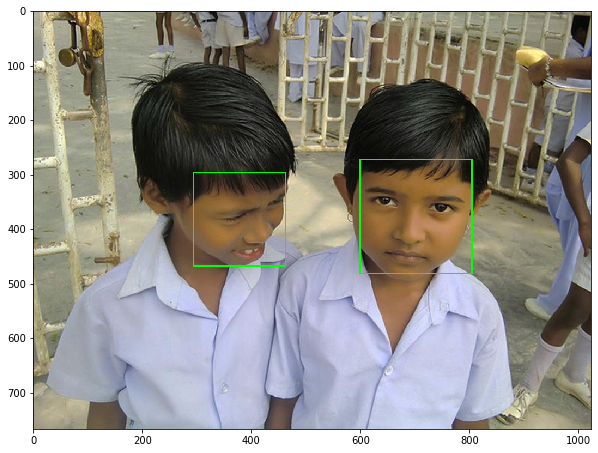

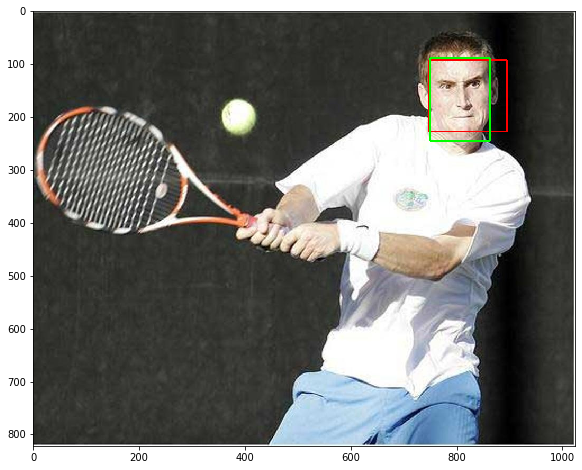

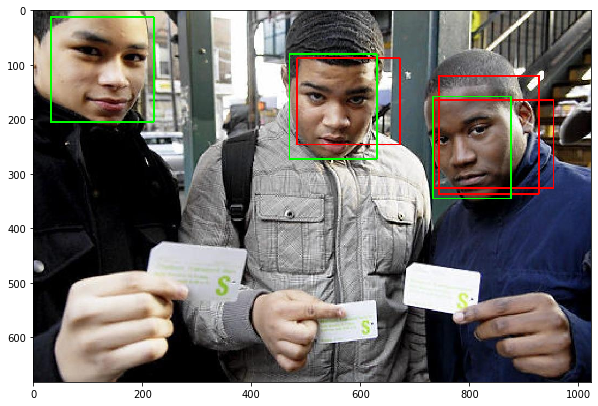

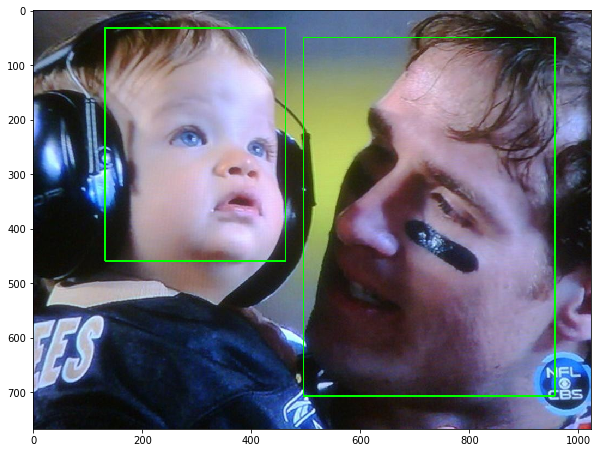

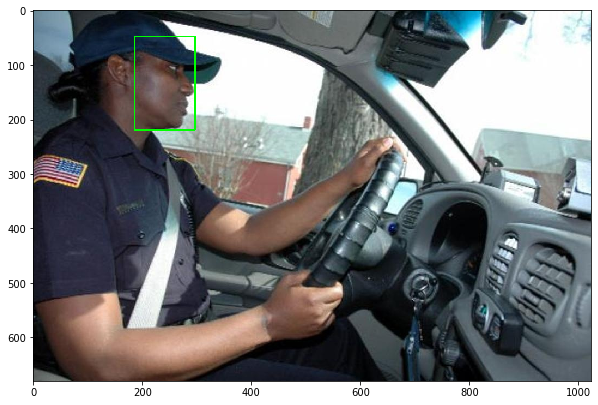

In [483]:
# OK, let's train the model
# you need to tune the hyper parameters
# you should be able to get an AP over 0.85 on the validation set using the best model.
train_and_validate(
    lr=0.01, 
    loss_reg_weight=0.01, 
    imagenet_pretrain=True, 
    device='cuda:0'
    
)

<font size='4' color='red'>**Task 3.5: Compare the effectiveness of the ImageNet pre-trained model (11 points).**</font>

==> Loading gt boxes from file.
==> Loading object proposals from file.
==> Getting ground-truths for each object proposal
faces/train/0_Parade_marchingband_1_353.jpg, 0.0
faces/train/16_Award_Ceremony_Awards_Ceremony_16_116.jpg, 0.0
faces/train/17_Ceremony_Ceremony_17_1007.jpg, 0.0
faces/train/17_Ceremony_Ceremony_17_972.jpg, 0.0
faces/train/19_Couple_Couple_19_88.jpg, 0.0
faces/train/19_Couple_Couple_19_631.jpg, 0.0
faces/train/19_Couple_Couple_19_90.jpg, 0.0
faces/train/19_Couple_Couple_19_349.jpg, 0.0
faces/train/19_Couple_Couple_19_822.jpg, 0.0
faces/train/20_Family_Group_Family_Group_20_750.jpg, 0.0
faces/train/21_Festival_Festival_21_664.jpg, 0.0
faces/train/22_Picnic_Picnic_22_561.jpg, 0.0
==> Loading gt boxes from file.
==> Loading object proposals from file.
==> Getting ground-truths for each object proposal
faces/val/25_Soldier_Patrol_Soldier_Patrol_25_513.jpg, 0.0


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


iter: 0000/1000, loss_cls: 0.630, loss_reg: 0.031668, loss: 0.661, lr: 0.009990
iter: 0010/1000, loss_cls: 1.051, loss_reg: 0.017188, loss: 1.069, lr: 0.009891
iter: 0020/1000, loss_cls: 0.976, loss_reg: 0.007420, loss: 0.984, lr: 0.009792
iter: 0030/1000, loss_cls: 0.686, loss_reg: 0.616578, loss: 1.302, lr: 0.009695
iter: 0040/1000, loss_cls: 0.711, loss_reg: 0.009831, loss: 0.721, lr: 0.009598
iter: 0050/1000, loss_cls: 0.596, loss_reg: 0.027363, loss: 0.623, lr: 0.009503
iter: 0060/1000, loss_cls: 0.641, loss_reg: 0.029514, loss: 0.670, lr: 0.009408
iter: 0070/1000, loss_cls: 0.591, loss_reg: 0.021214, loss: 0.612, lr: 0.009314
iter: 0080/1000, loss_cls: 0.477, loss_reg: 0.024281, loss: 0.502, lr: 0.009222
iter: 0090/1000, loss_cls: 0.532, loss_reg: 0.005730, loss: 0.538, lr: 0.009130
Epoch: 0000, AP: 0.150
iter: 0100/1000, loss_cls: 1.134, loss_reg: 0.170968, loss: 1.305, lr: 0.009039
iter: 0110/1000, loss_cls: 0.645, loss_reg: 0.011804, loss: 0.657, lr: 0.008949
iter: 0120/1000, 

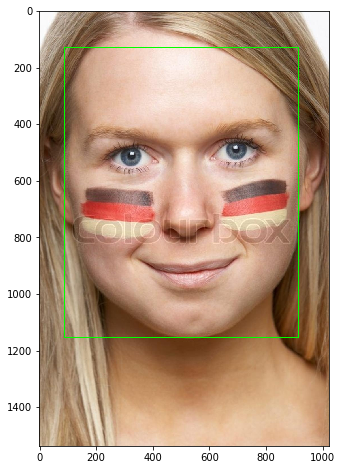

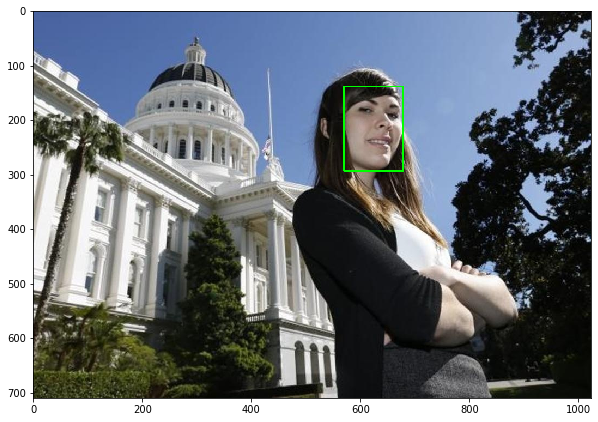

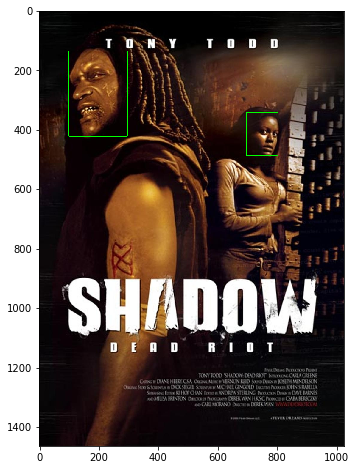

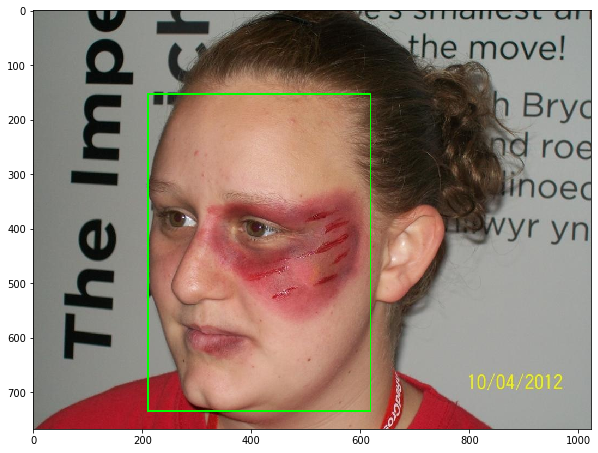

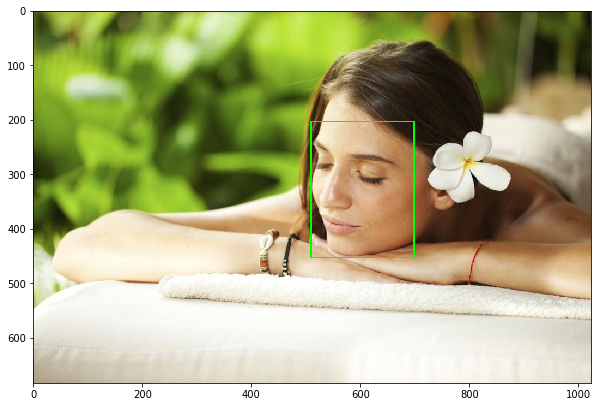

In [414]:
# now train your model using the same hyper parameters but without using the ImageNet pre-trained model
train_and_validate(
    lr=0.01, 
    loss_reg_weight=0.01, 
    imagenet_pretrain=False, 
    device='cuda:0'
)

**Explain below the accuracy difference of with and without using the ImageNet-pre-trained model**

The fundamental difference with using a backbone ResNet architecture allows us to train extremely deep neural networks efficiently. Increasing network depth does not work by simply stacking layers together as Deep networks are hard to train, mainly because of the notorious vanishing gradient problem — as the gradient is back-propagated to previous layers, repeated multiplication may make the gradient extremely minute. As a result, as the network goes deeper, its performance gets saturated or even starts degrading rapidly. The accuracy with using the ImageNet pre-trained model is seemed to be much higher than without using the ImageNet pre-trained model.